In [162]:
!pip install rarfile


In [163]:
import os
import numpy as np
from skimage import io, color, transform
from PIL import Image
from sklearn.model_selection import train_test_split
import tarfile
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


In [164]:
# Specify the path to the uploaded TGZ file
tgz_file_path = '/content/EnglishImg.tgz'

# Specify the directory where you want to extract the contents
extraction_path = '/data_set'

# Extract the TGZ archive
with tarfile.open(tgz_file_path, 'r:gz') as tgz_ref:
    tgz_ref.extractall(extraction_path)


## The dataset was initially provided in a compressed TGZ file format. To make it accessible for analysis, the data was loaded by decompressing the TGZ archive. This process involved specifying the path to the uploaded TGZ file and designating a target directory for the extraction of dataset contents. The `tarfile` library was employed to efficiently extract the data, making it ready for subsequent processing and utilization in the analysis.

In [165]:

parent_directory = '/data_set/English/Img/GoodImg/Bmp'

# List of folder names
folder_names = ['Sample005', 'Sample011', 'Sample057', 'Sample044']

# Initialize lists to store images and their labels
images = []
labels = []

# Loop through each folder
for folder_name in folder_names:
    folder_path = os.path.join(parent_directory, folder_name)

    # Loop through image files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            image_path = os.path.join(folder_path, filename)
            img = io.imread(image_path)
            img_gray = color.rgb2gray(img)  # Convert to grayscale
            img_resized = transform.resize(img_gray, (64, 64))
            # Append the image and its label (folder name) to the lists
            images.append(img_resized)
            labels.append(folder_names.index(folder_name))# Use numerical labels
# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)


This section extracts image data from a TGZ archive file converts them to gray and resizes the images to a common size (64x64 pixels).

In [166]:
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)


Images shape: (698, 64, 64)
Labels shape: (698,)


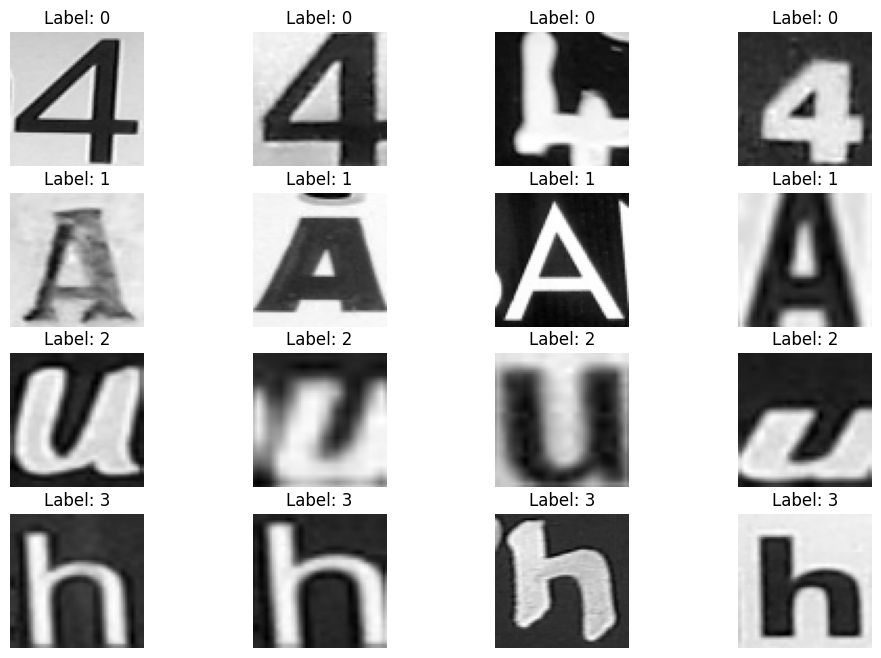

In [167]:

# Define the number of sample images to display from each folder
num_samples_per_folder = 4

# Create a list to store sample indices
sample_indices = []

# Loop through each folder
for folder_name in folder_names:
    folder_indices = np.where(labels == folder_names.index(folder_name))[0]
    sample_indices.extend(folder_indices[:num_samples_per_folder])

# Create a subplot for each sample image
plt.figure(figsize=(12, 8))
for i, index in enumerate(sample_indices):
    plt.subplot(len(folder_names), num_samples_per_folder, i + 1)
    plt.imshow(images[index], cmap='gray')
    plt.title(f'Label: {labels[index]}')
    plt.axis('off')

plt.show()


In [168]:
# Filter the data to include only '4' and 'A' images
selected_classes = [0, 1]

# Initialize lists to store filtered images and their labels
filtered_images = []
filtered_labels = []

# Loop through each image and label
for image, label in zip(images, labels):
    if label in selected_classes:
        filtered_images.append(image)
        filtered_labels.append(label)

# Convert lists to numpy arrays
filtered_images = np.array(filtered_images)
filtered_labels = np.array(filtered_labels)


# ***Random Binary Classifiers***

In [169]:
# Split the filtered data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    filtered_images, filtered_labels, test_size=0.3, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.6, random_state=42)

# Check the number of images in each set
print("Number of Training Images:", len(X_train))
print("Number of Validation Images:", len(X_valid))
print("Number of Test Images:", len(X_test))

Number of Training Images: 423
Number of Validation Images: 72
Number of Test Images: 110


In [170]:

# Create and train the logistic regression model
clf = LogisticRegression(random_state=42, solver='liblinear')
clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Predict labels for the validation and test sets
y_train_pred = clf.predict(X_train.reshape(X_train.shape[0], -1))
y_valid_pred = clf.predict(X_valid.reshape(X_valid.shape[0], -1))
y_test_pred = clf.predict(X_test.reshape(X_test.shape[0], -1))


In [171]:

# Calculate confusion matrix for training and test sets
conf_matrix_train = np.zeros((2, 2), dtype=int)
conf_matrix_test = np.zeros((2, 2), dtype=int)

for true_label, predicted_label in zip(y_train, y_train_pred):
    conf_matrix_train[true_label][predicted_label] += 1

for true_label, predicted_label in zip(y_test, y_test_pred):
    conf_matrix_test[true_label][predicted_label] += 1

print("\nConfusion Matrix for Training Data:")
print(conf_matrix_train)

print("\nConfusion Matrix for Test Data:")
print(conf_matrix_test)




Confusion Matrix for Training Data:
[[ 29   3]
 [  0 391]]

Confusion Matrix for Test Data:
[[ 4  5]
 [ 5 96]]


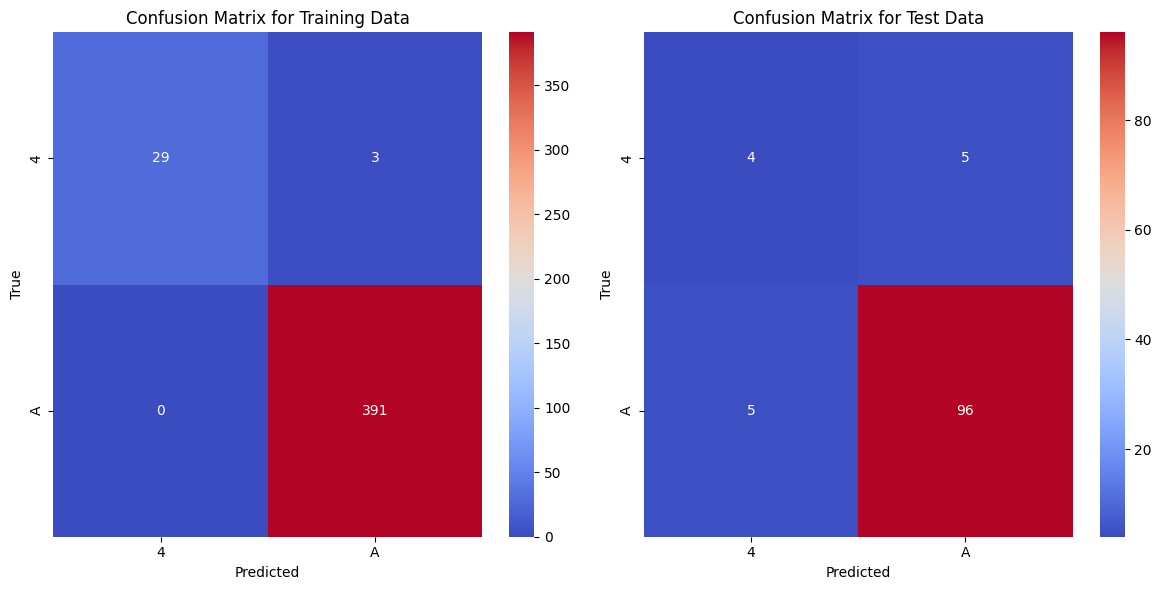

In [172]:

# Define a function to plot the confusion matrix
def plot_confusion_matrix(confusion_matrix, labels, title, ax):
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

# Define your class labels (e.g., '4' and 'A')
class_labels = ['4', 'A']

# Create subplots for both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the confusion matrix for validation data
plot_confusion_matrix(conf_matrix_train, class_labels, "Confusion Matrix for Training Data", axes[0])

# Plot the confusion matrix for test data
plot_confusion_matrix(conf_matrix_test, class_labels, "Confusion Matrix for Test Data", axes[1])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [173]:
# Calculate accuracy, precision, recall and f1 score for Training and test sets

accuracy_train = np.mean(y_train_pred == y_train)
precision_Train = conf_matrix_train[1, 1] / (conf_matrix_train[1, 1] + conf_matrix_train[0, 1])
recall_Train = conf_matrix_train[1, 1] / (conf_matrix_train[1, 1] + conf_matrix_train[1, 0])
f1_score_train = 2 * (precision_Train * recall_Train) / (precision_Train + recall_Train)


accuracy_test = np.mean(y_test_pred == y_test)
precision_test = conf_matrix_test[1, 1] / (conf_matrix_test[1, 1] + conf_matrix_test[0, 1])
recall_test = conf_matrix_test[1, 1] / (conf_matrix_test[1, 1] + conf_matrix_test[1, 0])
f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)


print("\nTraining Accuracy:", accuracy_train)
print("Training Precision:", precision_Train)
print("Training Recall:", recall_Train)
print("Training F1 score:", f1_score_train)

print("\nTest Accuracy:", accuracy_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)
print("Test F1 score:", f1_score_test)



Training Accuracy: 0.9929078014184397
Training Precision: 0.9923857868020305
Training Recall: 1.0
Training F1 score: 0.9961783439490446

Test Accuracy: 0.9090909090909091
Test Precision: 0.9504950495049505
Test Recall: 0.9504950495049505
Test F1 score: 0.9504950495049505


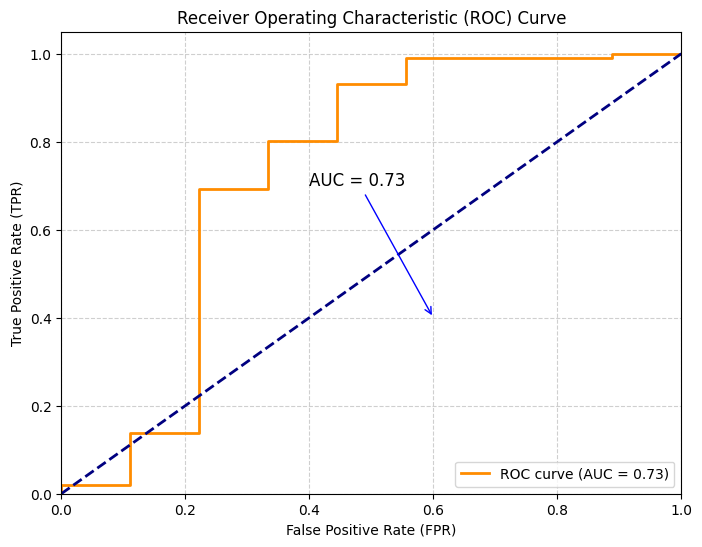

In [174]:

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1])
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Annotate the plot with the AUC score
plt.annotate(f'AUC = {roc_auc:.2f}', xy=(0.6, 0.4), xytext=(0.4, 0.7), fontsize=12,
             arrowprops=dict(arrowstyle='->', lw=1, color='blue'))

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


# **Stratified Binary Class**

In [175]:
# Split the filtered data into training, validation, and test sets
X_train1, X_temp1, y_train1, y_temp1 = train_test_split(
    filtered_images, filtered_labels, test_size=0.3, random_state=42,stratify=filtered_labels)

X_valid1, X_test1, y_valid1, y_test1 = train_test_split(
    X_temp1, y_temp1, test_size=0.6, random_state=42,stratify=y_temp1)

# Check the number of images in each set
print("Number of Training Images:", len(X_train))
print("Number of Validation Images:", len(X_valid))
print("Number of Test Images:", len(X_test))

Number of Training Images: 423
Number of Validation Images: 72
Number of Test Images: 110


In [176]:

# Create and train the logistic regression model
clf1 = LogisticRegression(random_state=42, solver='liblinear')
clf1.fit(X_train1.reshape(X_train1.shape[0], -1), y_train1)

# Predict labels for the validation and test sets
y_train_pred1 = clf.predict(X_train1.reshape(X_train1.shape[0], -1))
y_valid_pred1 = clf.predict(X_valid1.reshape(X_valid1.shape[0], -1))
y_test_pred1 = clf.predict(X_test1.reshape(X_test1.shape[0], -1))


In [177]:

# Calculate confusion matrix for training and test sets
conf_matrix_train1 = np.zeros((2, 2), dtype=int)
conf_matrix_test1 = np.zeros((2, 2), dtype=int)

for true_label, predicted_label in zip(y_train1, y_train_pred1):
    conf_matrix_train1[true_label][predicted_label] += 1

for true_label, predicted_label in zip(y_test1, y_test_pred1):
    conf_matrix_test1[true_label][predicted_label] += 1

print("\nConfusion Matrix for Training Data:")
print(conf_matrix_train1)

print("\nConfusion Matrix for Test Data:")
print(conf_matrix_test1)




Confusion Matrix for Training Data:
[[ 25   8]
 [  3 387]]

Confusion Matrix for Test Data:
[[  5   3]
 [  1 101]]


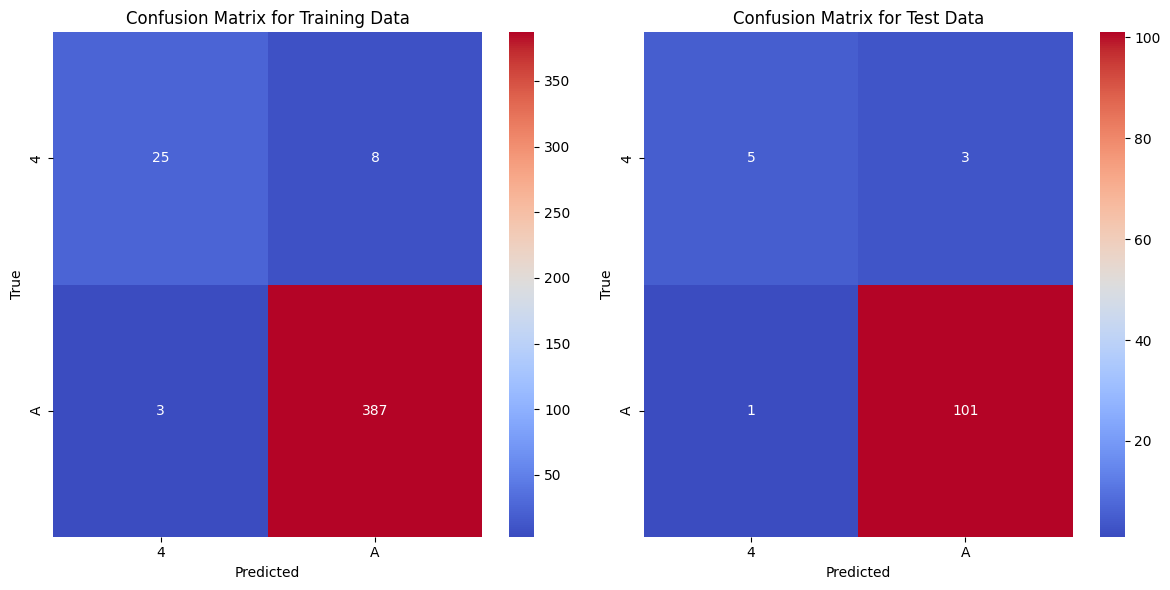

In [178]:

# Define a function to plot the confusion matrix
def plot_confusion_matrix(confusion_matrix, labels, title, ax):
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="coolwarm", xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

# Define your class labels (e.g., '4' and 'A')
class_labels = ['4', 'A']

# Create subplots for both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the confusion matrix for validation data
plot_confusion_matrix(conf_matrix_train1, class_labels, "Confusion Matrix for Training Data", axes[0])

# Plot the confusion matrix for test data
plot_confusion_matrix(conf_matrix_test1, class_labels, "Confusion Matrix for Test Data", axes[1])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()


In [188]:
# Calculate accuracy, precision, recall and f1 score for Training and test sets

accuracy_train = np.mean(y_train_pred1 == y_train1)
precision_Train = conf_matrix_train1[1, 1] / (conf_matrix_train1[1, 1] + conf_matrix_train1[0, 1])
recall_Train = conf_matrix_train1[1, 1] / (conf_matrix_train1[1, 1] + conf_matrix_train1[1, 0])
f1_score_train = 2 * (precision_Train * recall_Train) / (precision_Train + recall_Train)


accuracy_test = np.mean(y_test_pred1 == y_test1)
precision_test = conf_matrix_test1[1, 1] / (conf_matrix_test1[1, 1] + conf_matrix_test1[0, 1])
recall_test = conf_matrix_test1[1, 1] / (conf_matrix_test1[1, 1] + conf_matrix_test1[1, 0])
f1_score_test = 2 * (precision_test * recall_test) / (precision_test + recall_test)


print("\nTraining Accuracy:", accuracy_train)
print("Training Precision:", precision_Train)
print("Training Recall:", recall_Train)
print("Training F1 score:", f1_score_train)

print("\nTest Accuracy:", accuracy_test)
print("Test Precision:", precision_test)
print("Test Recall:", recall_test)
print("Test F1 score:", f1_score_test)



Training Accuracy: 0.9739952718676123
Training Precision: 0.979746835443038
Training Recall: 0.9923076923076923
Training F1 score: 0.9859872611464969

Test Accuracy: 0.9636363636363636
Test Precision: 0.9711538461538461
Test Recall: 0.9901960784313726
Test F1 score: 0.9805825242718447


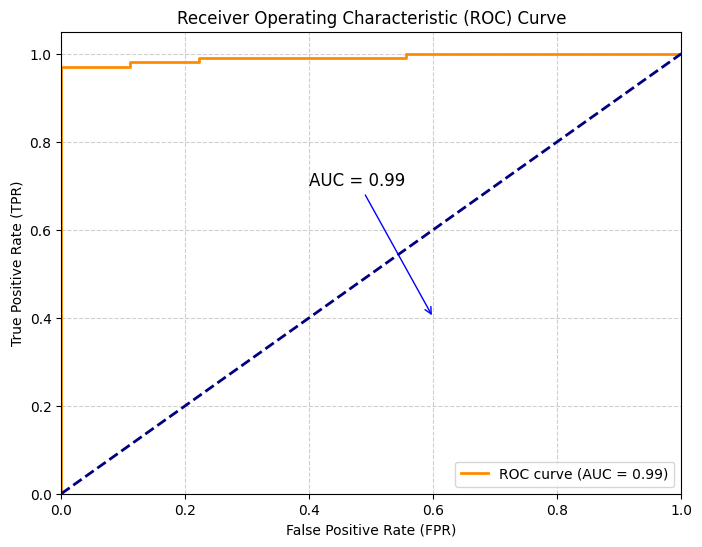

In [180]:

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, clf1.predict_proba(X_test.reshape(X_test.shape[0], -1))[:, 1])
roc_auc = auc(fpr, tpr)

# Create the ROC curve plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Annotate the plot with the AUC score
plt.annotate(f'AUC = {roc_auc:.2f}', xy=(0.6, 0.4), xytext=(0.4, 0.7), fontsize=12,
             arrowprops=dict(arrowstyle='->', lw=1, color='blue'))

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()


## **When fitting the model using random data splitting, it's important to note that the accuracy was initially higher for the training set compared to the model trained with stratified splitting. However, this higher training accuracy in random splitting can be misleading. The reason lies in the potential class imbalance within the random training set. This can lead to overfitting, where the model becomes overly tailored to the majority class, achieving high accuracy on the training data but struggling to generalize to unseen or minority class examples in the test set. On the other hand, stratified splitting mitigates class imbalance, ensuring a more representative distribution in both training and test sets. As a result, the model trained with stratified sampling performs better on the test set, providing a more reliable evaluation of its performance across all classes.**

In [189]:
# Split the filtered data into training, validation, and test sets with stratified sampling
X_train2, X_temp2, y_train2, y_temp2 = train_test_split(
    images, labels, test_size=0.4, random_state=42,stratify=labels)

X_valid2, X_test2, y_valid2, y_test2 = train_test_split(
    X_temp2, y_temp2, test_size=0.5, random_state=42,stratify=y_temp2)

# Check the number of images in each set
print("Number of Training Images:", len(X_train2))
print("Number of Validation Images:", len(X_valid2))
print("Number of Test Images:", len(X_test2))


Number of Training Images: 418
Number of Validation Images: 140
Number of Test Images: 140


In [190]:

# Train a multiclass logistic regression model
clf2 = LogisticRegression( max_iter=1000 ,multi_class='ovr', random_state=42)
clf2.fit(X_train2.reshape(X_train2.shape[0], -1), y_train2)

# Predict labels for the Train and test sets
y_train_pred2 = clf2.predict(X_train2.reshape(X_train2.shape[0], -1))

y_test_pred2 = clf2.predict(X_test2.reshape(X_test2.shape[0], -1))



In [191]:

# Calculate the confusion matrix for the training set
confusion_matrix_train2 = confusion_matrix(y_train2, y_train_pred2)

# Calculate the confusion matrix for the test set
confusion_matrix_test2 = confusion_matrix(y_test2, y_test_pred2)

# Print the confusion matrices
print("Confusion Matrix for Training Data:")
print(confusion_matrix_train2)

print("\nConfusion Matrix for Test Data:")
print(confusion_matrix_test2)



Confusion Matrix for Training Data:
[[ 24   4   0   0]
 [  0 334   0   0]
 [  0   2  23   0]
 [  0   7   0  24]]

Confusion Matrix for Test Data:
[[  3   6   1   0]
 [  1 108   1   2]
 [  1   5   2   0]
 [  0   7   0   3]]


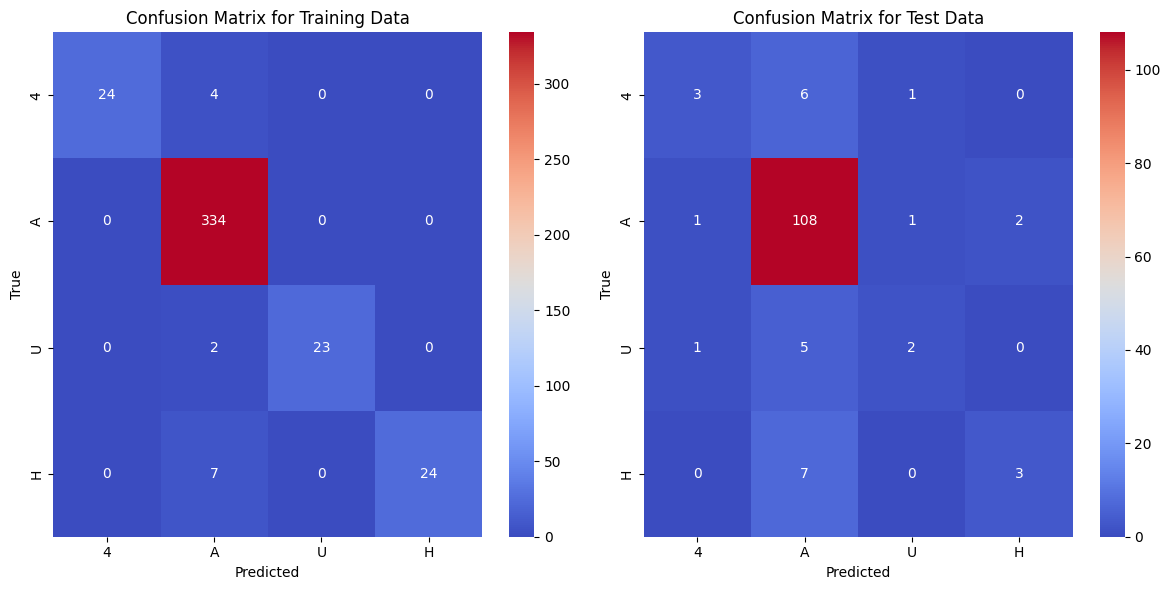

In [192]:
# Define your class labels (e.g., '4' and 'A')
class_labels = ['4', 'A','U','H']

# Create subplots for both confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the confusion matrix for validation data
plot_confusion_matrix(confusion_matrix_train2, class_labels, "Confusion Matrix for Training Data", axes[0])

# Plot the confusion matrix for test data
plot_confusion_matrix(confusion_matrix_test2, class_labels, "Confusion Matrix for Test Data", axes[1])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [193]:
def accuracy(confusion_matrix):
    correct_predictions = np.trace(confusion_matrix)
    total_predictions = np.sum(confusion_matrix)
    return correct_predictions / total_predictions

# Define a function to calculate recall for each class
def recall(confusion_matrix):
    recalls = []
    for i in range(len(confusion_matrix)):
        true_positive = confusion_matrix[i, i]
        false_negatives = np.sum(confusion_matrix[i, :]) - true_positive
        recalls.append(true_positive / (true_positive + false_negatives))
    return recalls

# Define a function to calculate precision for each class
def precision(confusion_matrix):
    precisions = []
    for i in range(len(confusion_matrix)):
        true_positive = confusion_matrix[i, i]
        false_positives = np.sum(confusion_matrix[:, i]) - true_positive
        precisions.append(true_positive / (true_positive + false_positives))
    return precisions

# Define a function to calculate F1 score for each class
def f1_score(confusion_matrix):
    prec = precision(confusion_matrix)
    rec = recall(confusion_matrix)
    f1_scores = []
    for i in range(len(confusion_matrix)):
        f1_scores.append(2 * (prec[i] * rec[i]) / (prec[i] + rec[i]))
    return f1_scores

In [194]:
# Calculate and print metrics for the testing data
print("\nMetrics for Training Data:")
for i, label in enumerate(class_labels):
    print(f"Metrics for {label}:")
    print(f"Accuracy: {accuracy(confusion_matrix_train2):.4f}")
    print(f"Recall: {recall(confusion_matrix_train2)[i]:.4f}")
    print(f"Precision: {precision(confusion_matrix_train2)[i]:.4f}")
    print(f"F1 Score: {f1_score(confusion_matrix_train2)[i]:.4f}")
    print()

# Calculate and print average metrics for testing data
average_accuracy_test = np.mean(accuracy(confusion_matrix_train2))
average_recall_test = np.mean(recall(confusion_matrix_train2))
average_precision_test = np.mean(precision(confusion_matrix_train2))
average_f1_score_test = np.mean(f1_score(confusion_matrix_train2))

print("Average Metrics for Testing Data:")
print(f"Average Accuracy: {average_accuracy_test:.4f}")
print(f"Average Recall: {average_recall_test:.4f}")
print(f"Average Precision: {average_precision_test:.4f}")
print(f"Average F1 Score: {average_f1_score_test:.4f}")


Metrics for Training Data:
Metrics for 4:
Accuracy: 0.9689
Recall: 0.8571
Precision: 1.0000
F1 Score: 0.9231

Metrics for A:
Accuracy: 0.9689
Recall: 1.0000
Precision: 0.9625
F1 Score: 0.9809

Metrics for U:
Accuracy: 0.9689
Recall: 0.9200
Precision: 1.0000
F1 Score: 0.9583

Metrics for H:
Accuracy: 0.9689
Recall: 0.7742
Precision: 1.0000
F1 Score: 0.8727

Average Metrics for Testing Data:
Average Accuracy: 0.9689
Average Recall: 0.8878
Average Precision: 0.9906
Average F1 Score: 0.9338


In [195]:
# Calculate and print metrics for the testing data
print("\nMetrics for Testing Data:")
for i, label in enumerate(class_labels):
    print(f"Metrics for {label}:")
    print(f"Accuracy: {accuracy(confusion_matrix_test2):.4f}")
    print(f"Recall: {recall(confusion_matrix_test2)[i]:.4f}")
    print(f"Precision: {precision(confusion_matrix_test2)[i]:.4f}")
    print(f"F1 Score: {f1_score(confusion_matrix_test2)[i]:.4f}")
    print()

# Calculate and print average metrics for testing data
average_accuracy_test = np.mean(accuracy(confusion_matrix_test2))
average_recall_test = np.mean(recall(confusion_matrix_test2))
average_precision_test = np.mean(precision(confusion_matrix_test2))
average_f1_score_test = np.mean(f1_score(confusion_matrix_test2))

print("Average Metrics for Testing Data:")
print(f"Average Accuracy: {average_accuracy_test:.4f}")
print(f"Average Recall: {average_recall_test:.4f}")
print(f"Average Precision: {average_precision_test:.4f}")
print(f"Average F1 Score: {average_f1_score_test:.4f}")


Metrics for Testing Data:
Metrics for 4:
Accuracy: 0.8286
Recall: 0.3000
Precision: 0.6000
F1 Score: 0.4000

Metrics for A:
Accuracy: 0.8286
Recall: 0.9643
Precision: 0.8571
F1 Score: 0.9076

Metrics for U:
Accuracy: 0.8286
Recall: 0.2500
Precision: 0.5000
F1 Score: 0.3333

Metrics for H:
Accuracy: 0.8286
Recall: 0.3000
Precision: 0.6000
F1 Score: 0.4000

Average Metrics for Testing Data:
Average Accuracy: 0.8286
Average Recall: 0.4536
Average Precision: 0.6393
Average F1 Score: 0.5102


## **I applied logistic regression for multiclass classification, and the model was trained using stratified data splitting to address the inherent data imbalance. Notably, the accuracy achieved on both the training and testing sets was higher when compared to the results obtained from randomly splitting the data. This outcome can be attributed to the benefits of stratified sampling, which ensures a more balanced distribution of classes in the training and testing subsets. By doing so, the model receives better exposure to all classes during training, resulting in improved generalization performance on unseen data.**